In [1]:
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

import os
import glob
from tqdm import tqdm

from util import load_positive_samples, load_negative_samples

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2

In [2]:
positive_samples = load_positive_samples()
negative_samples = load_negative_samples()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:23<00:00,  2.41it/s]


In [3]:
def plot_img(samples, select_num=6):   
    num_samples = len(samples)
    selected_index = np.random.choice(num_samples, select_num, replace=True)
    
    count = 0
    for index in selected_index:
        count += 1     
        plt_idx = count
        plt.subplot(1, select_num, plt_idx)
        plt.imshow(samples[index])
        plt.axis('off')
        
    plt.show()

19760


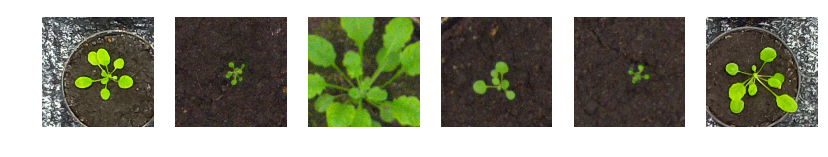

In [8]:
print(len(positive_samples))
plot_img(positive_samples)

74933


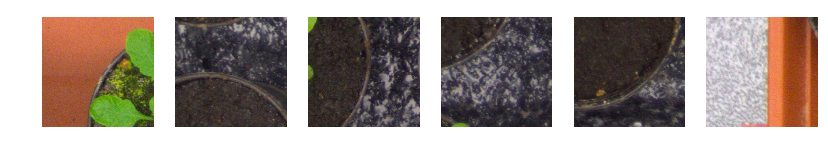

In [7]:
print(len(negative_samples))
plot_img(negative_samples)

In [9]:
from sklearn.model_selection import train_test_split

labels = []
fds = []
for sample in positive_samples:
    sample = np.transpose(sample)
    fds.append(sample[:3,:,:])
    labels.append([1, 0])

shuffle(negative_samples)
for sample in negative_samples[:40000]:
    sample = np.transpose(sample)
    fds.append(sample[:3,:,:])
    labels.append([0, 1])


del positive_samples
del negative_samples


X_train, X_test, y_train, y_test = train_test_split(
    fds, labels, test_size=0.3, random_state=0)

## Training

In [ ]:
from squeezenet import SqueezeNet

model, callback_list = SqueezeNet(nb_classes=2)
hist = model.fit(np.array(X_train), np.array(y_train), batch_size=64, epochs=5, verbose=1, 
                callbacks=callback_list, validation_split=0.3, validation_data=None, 
                shuffle=True, initial_epoch=0)

Using TensorFlow backend.


squeezeNet model summary: 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 96, 112, 112)  14208                                        
____________________________________________________________________________________________________
maxpool1 (MaxPooling2D)          (None, 96, 55, 55)    0                                            
____________________________________________________________________________________________________
fire2_squeeze (Conv2D)           (None, 16, 55, 55)    1552                                         
________________________________________________________________

## Testing

In [2]:
from squeezenet import SqueezeNet

model, callback_list = SqueezeNet(nb_classes=2, is_testing=True)

Using TensorFlow backend.


## Object Detection

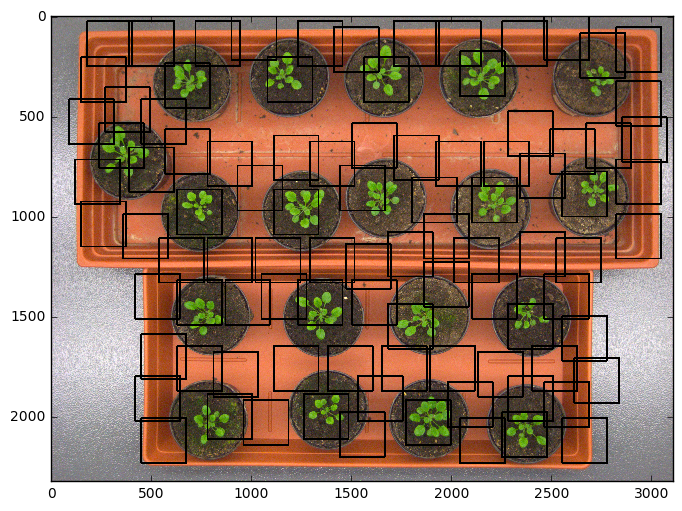

In [11]:
import cv2
from util import nms
from util import sliding_window

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x[0]) / np.sum(np.exp(x))

min_window_size = (224, 224)
step_size = (20, 20)
confidence_threshold = 0.6
threshold = 0.05

detections = []

current_path = os.getcwd()
img_path = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2012', 'ara2012_tray01_rgb.png')
im = imread(img_path)

candidate_imgs = []
coordinates = []
for (x, y, im_window) in sliding_window(im, min_window_size, step_size):
        if im_window.shape[0] != min_window_size[0] or im_window.shape[1] != min_window_size[1]:
            continue
        candidate_imgs.append(im_window)
        coordinates.append([x, y])

candidate_imgs = np.array(candidate_imgs)
pred = model.predict(np.reshape(candidate_imgs, (candidate_imgs.shape[0], 3, 224, 224)))

for i, score in enumerate(pred):
    confidence = softmax(score)
    if confidence > confidence_thresholds:
        detections.append((coordinates[i][0], coordinates[i][1], confidence,
            int(min_window_size[0]),
            int(min_window_size[1])))

# Display the results before performing NMS
clone = im.copy()

# Perform Non Maxima Suppression
left_detections = nms(detections, threshold)

# Display the results after performing NMS
for (x_tl, y_tl, _, w, h) in left_detections:
    # Draw the detections
    cv2.rectangle(clone, (x_tl, y_tl), (x_tl+w,y_tl+h), (0, 0, 0), thickness=8)

plt.figure()
plt.imshow(clone)
plt.show()